In [1]:
import os

# Extract each pdf page to image
from pdf2image import convert_from_path, convert_from_bytes 
from pdf2image.exceptions import (
 PDFInfoNotInstalledError,
 PDFPageCountError,
 PDFSyntaxError
)

# Image Processing
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pytesseract
import json
import requests
from pathlib import Path
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [206]:
base_correct = "ChartExtraction_Output/base_correct/"
base_wrong = "ChartExtraction_Output/base_wrong/" 

filter1_correct = "ChartExtraction_Output/filter_1_correct/"
filter1_wrong = "ChartExtraction_Output/filter_1_wrong/" 

filter2_correct = "ChartExtraction_Output/filter_2_correct/"
filter2_wrong = "ChartExtraction_Output/filter_2_wrong/" 

directory = filter1_correct
directory_2 = filter1_wrong
df = []

In [207]:
def process_Num(text):
    no_punct = re.sub('[^0-9\n\.]', ' ', text)
    res = no_punct.split()
    my_list = set(res)  
    to_delete = ["."]
    
    my_list.difference_update(to_delete)
    results = list(my_list)
    return results

def process_text(text):
    no_punct = re.sub('[^a-zA-Z\n\.]', ' ', text)
    res = no_punct.split()
    my_list = set(res)  
    to_delete = ["."]
    
    my_list.difference_update(to_delete)
    results = list(my_list)
    return results

def find_keywords(text):
    no_punct = re.sub('[^a-zA-Z0-9\n\.]', ' ', text)
    # list of keywords
    dictionary = ['carbon','ghg','emission',
                 'emissions',"scope", "WACI","net-zero",
                 'energy','water','waste','coal','power','green','paper','consumption','renewable',
                 'breakdown','loans','tonnes', 'tons', 'kWh', 'kg', 'kilogram', 'kilowatt hour', 
                   'gigajoules', 'GJ', 'litre', 'liter', 'CO2e', 'tCO', 't CO', 'MWh', 
                   'megawatt hour', '%', 'cubic metres', 'per employee','m3', 'co2','o2'
                    ,'million', 'total','trillion','set'
               ]
    res = set(no_punct.lower().split())
    newlength = len(res)
    res.difference_update(dictionary)
    results = list(res)
    value = newlength - len(results) 
    return value

def getTotalLen(text):
    no_punct = re.sub('[^a-zA-Z0-9\n\.]', ' ', text) # remove punctuations
    res = no_punct.split()
    return len(res)

def count_clean_text(text):
    no_punct = re.sub('[^a-zA-Z\n\.]', ' ', text)
    res = no_punct.split()
    return len(res)

def count_clean_num(text):
    no_punct = re.sub('[^0-9\n\.]', ' ', text)
    res = no_punct.split()
    return len(res)
    

def filter_image(source, actual): 
    img = cv2.imread(source, cv2.IMREAD_COLOR) # Identify img
    
    # Color filtering process
    # Filter by BW instead of colors, cause too similar
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    dilate_raw = cv2.mean(dilate)[::-1]
    dr = int(dilate_raw[3])
    
    try:
        text = pytesseract.image_to_string(img)
    except: 
        print("ERROR at Textserract")
        return
    
    # Filter images with too much text
    # Total length of text
    total_len = getTotalLen(text)
    
    # Filter images with too little or no keywords
    # Total unique ketywords found
    keywords = find_keywords(text)
    
    # Get total unique string
    textonly_len = len(process_text(text))
    
    # Get total unique numbers/digits
    numonly_len = len(process_Num(text))
    
    # Get text to total text ratio = clean_text/total text
    try:
        tt_ratio = count_clean_text(text)/total_len
    except:
        tt_ratio = 0
        
    # Get num to total text ratio = clean_text/total text********
    try:
        nt_ratio = count_clean_num(text)/total_len
    except:
        nt_ratio = 0
        
    # Basic shape descriptive data
    height = img.shape[0] 
    width = img.shape[1]
    channels = img.shape[2]# number of components used to represent each pixel.
    area = height * width
    
    # text to area ratio = total text to whole image 
    ta_ratio = count_clean_text(text)/area * 10**5
    
    # num to area ratio = total num to whole image 
    na_ratio = count_clean_num(text)/area * 10**5

    # Count total white and black ratio
    white_pix = np.sum(dilate == 255)
    black_pix = np.sum(dilate == 0)
    
    # w/b ratio
    wb_ratio = white_pix/black_pix
    
    # b/w ratio
    bw_ratio = black_pix/white_pix
    
    if(keywords>0 and tt_ratio < 0.99 and bw_ratio>14 and textonly_len<90 and numonly_len>1 and na_ratio>0.45 ):
        df.append([source,actual,dr, total_len, keywords, textonly_len, numonly_len, \
                   tt_ratio, nt_ratio, height, width, channels, area, ta_ratio,\
                  na_ratio,white_pix,black_pix,wb_ratio, bw_ratio\
                  ])
    

In [208]:
filtered = []
count = 0
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        count = count + 1
        if(count>50):
            break
        else:
            img_path = os.path.join(directory, filename)
            print(f"NOW DOING no:{count} ====>{img_path} ")
            isCorrect = filter_image(os.path.join(directory, filename), "CORRECT")
            print(f"END processing ====>{img_path} ")
            print("***************************************************")
    else:
        continue   
#print(f"performance: {len(filtered)}")

NOW DOING no:1 ====>ChartExtraction_Output/filter_1_correct/page70_0_12.png 
END processing ====>ChartExtraction_Output/filter_1_correct/page70_0_12.png 
***************************************************
NOW DOING no:2 ====>ChartExtraction_Output/filter_1_correct/page48_b_7.png 
END processing ====>ChartExtraction_Output/filter_1_correct/page48_b_7.png 
***************************************************
NOW DOING no:3 ====>ChartExtraction_Output/filter_1_correct/page49_a_133.png 
END processing ====>ChartExtraction_Output/filter_1_correct/page49_a_133.png 
***************************************************
NOW DOING no:4 ====>ChartExtraction_Output/filter_1_correct/page61_0_38.png 
END processing ====>ChartExtraction_Output/filter_1_correct/page61_0_38.png 
***************************************************
NOW DOING no:5 ====>ChartExtraction_Output/filter_1_correct/page49_a_4.png 
END processing ====>ChartExtraction_Output/filter_1_correct/page49_a_4.png 
************************

In [209]:
df_frame = pd.DataFrame (df, columns = ['source','actual','dr', 'total_len', 'keywords', 'textonly_len', 'numonly_len', \
                   'tt_ratio', 'nt_ratio', 'height', 'width', 'channels', 'area', 'ta_ratio',\
                  'na_ratio','white_pix','black_pix','wb_ratio', 'bw_ratio'\
                  ])
df_frame

,source,actual,dr,total_len,keywords,textonly_len,numonly_len,tt_ratio,nt_ratio,height,width,channels,area,ta_ratio,na_ratio,white_pix,black_pix,wb_ratio,bw_ratio
0,ChartExtraction_Output/filter_1_correct/page70...,CORRECT,8,61,4,36,9,0.918033,0.262295,1329,1654,3,2198166,2.547578,0.727880,71024,2127142,0.033389,29.949623
1,ChartExtraction_Output/filter_1_correct/page48...,CORRECT,10,48,5,19,16,0.729167,0.541667,679,1328,3,901712,3.881505,2.883404,38341,863371,0.044408,22.518218
2,ChartExtraction_Output/filter_1_correct/page49...,CORRECT,5,40,3,18,12,0.700000,0.425000,608,1565,3,951520,2.942660,1.786615,22011,929509,0.023680,42.229294
3,ChartExtraction_Output/filter_1_correct/page61...,CORRECT,14,134,7,88,14,0.947761,0.194030,754,1700,3,1281800,9.907942,2.028398,73807,1207993,0.061099,16.366916
4,ChartExtraction_Output/filter_1_correct/page49...,CORRECT,9,56,2,31,11,0.714286,0.321429,674,1654,3,1114796,3.588100,1.614645,39574,1075222,0.036805,27.169910
5,ChartExtraction_Output/filter_1_correct/page92...,CORRECT,7,51,2,30,19,0.803922,0.372549,1112,1654,3,1839248,2.229172,1.033031,54752,1784496,0.030682,32.592344
6,ChartExtraction_Output/filter_1_correct/page23...,CORRECT,15,56,3,34,8,0.821429,0.178571,998,1654,3,1650692,2.786710,0.605807,98901,1551791,0.063733,15.690347
7,ChartExtraction_Output/filter_1_correct/page92...,CORRECT,13,59,1,33,16,0.796610,0.288136,879,1654,3,1453866,3.232760,1.169296,77252,1376614,0.056117,17.819785
8,ChartExtraction_Output/filter_1_correct/page11...,CORRECT,15,174,7,70,50,0.637931,0.373563,912,1654,3,1508448,7.358557,4.309065,88924,1419524,0.062644,15.963339
9,ChartExtraction_Output/filter_1_correct/page19...,CORRECT,11,113,4,63,12,0.893805,0.141593,842,1733,3,1459186,6.921667,1.096502,67230,1391956,0.048299,20.704388


In [210]:
filtered = []
count = 0
for filename in os.listdir(directory_2):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        count = count + 1
        if(count>51110):
            break
        else:
            img_path = os.path.join(directory_2, filename)
            print(f"NOW DOING no:{count} ====>{img_path} ")
            isCorrect = filter_image(os.path.join(directory_2, filename), "WRONG")
            print(f"END processing ====>{img_path} ")
            print("***************************************************")
    else:
        continue   
#print(f"performance: {len(filtered)}")

NOW DOING no:1 ====>ChartExtraction_Output/filter_1_wrong/page150_b_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page150_b_1.png 
***************************************************
NOW DOING no:2 ====>ChartExtraction_Output/filter_1_wrong/page90_b_19.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page90_b_19.png 
***************************************************
NOW DOING no:3 ====>ChartExtraction_Output/filter_1_wrong/page165_a_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page165_a_1.png 
***************************************************
NOW DOING no:4 ====>ChartExtraction_Output/filter_1_wrong/page89_a_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page89_a_1.png 
***************************************************
NOW DOING no:5 ====>ChartExtraction_Output/filter_1_wrong/page71_0_38.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page71_0_38.png 
********************************************

END processing ====>ChartExtraction_Output/filter_1_wrong/page21_b_18.png 
***************************************************
NOW DOING no:43 ====>ChartExtraction_Output/filter_1_wrong/page135_0_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page135_0_1.png 
***************************************************
NOW DOING no:44 ====>ChartExtraction_Output/filter_1_wrong/page49_b_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page49_b_1.png 
***************************************************
NOW DOING no:45 ====>ChartExtraction_Output/filter_1_wrong/page84_0_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page84_0_1.png 
***************************************************
NOW DOING no:46 ====>ChartExtraction_Output/filter_1_wrong/page83_0_13.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page83_0_13.png 
***************************************************
NOW DOING no:47 ====>ChartExtraction_Output/filter_1_wrong/page21

END processing ====>ChartExtraction_Output/filter_1_wrong/page152_b_2.png 
***************************************************
NOW DOING no:84 ====>ChartExtraction_Output/filter_1_wrong/page141_a_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page141_a_1.png 
***************************************************
NOW DOING no:85 ====>ChartExtraction_Output/filter_1_wrong/page151_a_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page151_a_1.png 
***************************************************
NOW DOING no:86 ====>ChartExtraction_Output/filter_1_wrong/page40_a_3.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page40_a_3.png 
***************************************************
NOW DOING no:87 ====>ChartExtraction_Output/filter_1_wrong/page50_a_3.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page50_a_3.png 
***************************************************
NOW DOING no:88 ====>ChartExtraction_Output/filter_1_wrong/page89

END processing ====>ChartExtraction_Output/filter_1_wrong/page42_0_19.png 
***************************************************
NOW DOING no:125 ====>ChartExtraction_Output/filter_1_wrong/page32_0_5.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page32_0_5.png 
***************************************************
NOW DOING no:126 ====>ChartExtraction_Output/filter_1_wrong/page71_b_2.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page71_b_2.png 
***************************************************
NOW DOING no:127 ====>ChartExtraction_Output/filter_1_wrong/page3_0_11.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page3_0_11.png 
***************************************************
NOW DOING no:128 ====>ChartExtraction_Output/filter_1_wrong/page31_b_8.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page31_b_8.png 
***************************************************
NOW DOING no:129 ====>ChartExtraction_Output/filter_1_wrong/page6

END processing ====>ChartExtraction_Output/filter_1_wrong/page44_b_2.png 
***************************************************
NOW DOING no:166 ====>ChartExtraction_Output/filter_1_wrong/page42_0_2.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page42_0_2.png 
***************************************************
NOW DOING no:167 ====>ChartExtraction_Output/filter_1_wrong/page155_b_1.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page155_b_1.png 
***************************************************
NOW DOING no:168 ====>ChartExtraction_Output/filter_1_wrong/page70_0_9.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page70_0_9.png 
***************************************************
NOW DOING no:169 ====>ChartExtraction_Output/filter_1_wrong/page48_b_112.png 
END processing ====>ChartExtraction_Output/filter_1_wrong/page48_b_112.png 
***************************************************
NOW DOING no:170 ====>ChartExtraction_Output/filter_1_wrong/

In [211]:
df_frame = pd.DataFrame (df, columns = ['source','actual','dr', 'total_len', 'keywords', 'textonly_len', 'numonly_len', \
                   'tt_ratio', 'nt_ratio', 'height', 'width', 'channels', 'area', 'ta_ratio',\
                  'na_ratio','white_pix','black_pix','wb_ratio', 'bw_ratio'\
                  ])
df_frame
#df_frame.to_csv("results_filter1.csv")

,source,actual,dr,total_len,keywords,textonly_len,numonly_len,tt_ratio,nt_ratio,height,width,channels,area,ta_ratio,na_ratio,white_pix,black_pix,wb_ratio,bw_ratio
0,ChartExtraction_Output/filter_1_correct/page70...,CORRECT,8,61,4,36,9,0.918033,0.262295,1329,1654,3,2198166,2.547578,0.727880,71024,2127142,0.033389,29.949623
1,ChartExtraction_Output/filter_1_correct/page48...,CORRECT,10,48,5,19,16,0.729167,0.541667,679,1328,3,901712,3.881505,2.883404,38341,863371,0.044408,22.518218
2,ChartExtraction_Output/filter_1_correct/page49...,CORRECT,5,40,3,18,12,0.700000,0.425000,608,1565,3,951520,2.942660,1.786615,22011,929509,0.023680,42.229294
3,ChartExtraction_Output/filter_1_correct/page61...,CORRECT,14,134,7,88,14,0.947761,0.194030,754,1700,3,1281800,9.907942,2.028398,73807,1207993,0.061099,16.366916
4,ChartExtraction_Output/filter_1_correct/page49...,CORRECT,9,56,2,31,11,0.714286,0.321429,674,1654,3,1114796,3.588100,1.614645,39574,1075222,0.036805,27.169910
5,ChartExtraction_Output/filter_1_correct/page92...,CORRECT,7,51,2,30,19,0.803922,0.372549,1112,1654,3,1839248,2.229172,1.033031,54752,1784496,0.030682,32.592344
6,ChartExtraction_Output/filter_1_correct/page23...,CORRECT,15,56,3,34,8,0.821429,0.178571,998,1654,3,1650692,2.786710,0.605807,98901,1551791,0.063733,15.690347
7,ChartExtraction_Output/filter_1_correct/page92...,CORRECT,13,59,1,33,16,0.796610,0.288136,879,1654,3,1453866,3.232760,1.169296,77252,1376614,0.056117,17.819785
8,ChartExtraction_Output/filter_1_correct/page11...,CORRECT,15,174,7,70,50,0.637931,0.373563,912,1654,3,1508448,7.358557,4.309065,88924,1419524,0.062644,15.963339
9,ChartExtraction_Output/filter_1_correct/page19...,CORRECT,11,113,4,63,12,0.893805,0.141593,842,1733,3,1459186,6.921667,1.096502,67230,1391956,0.048299,20.704388


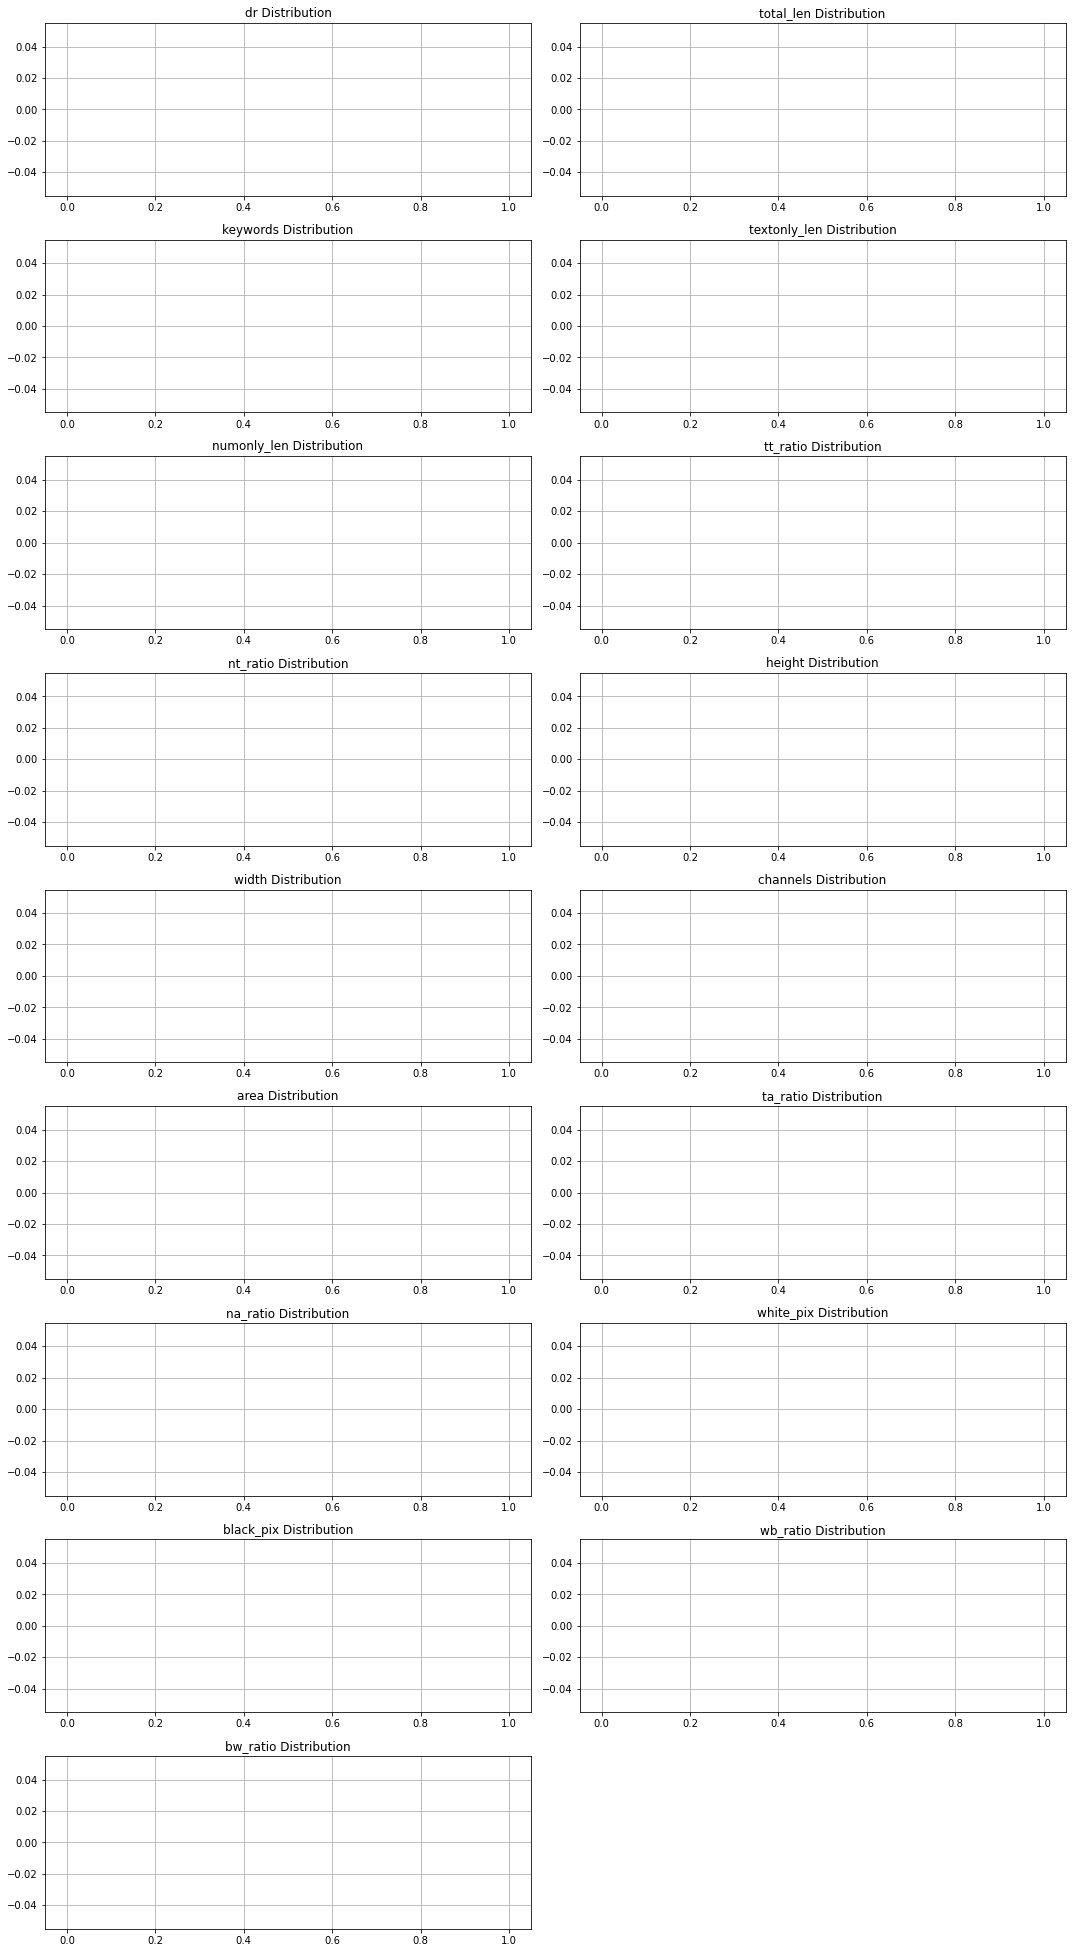

In [167]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,30))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

test = df_frame.drop(['source', 'actual'], axis = 1)
draw_histograms(test, test.columns, 10,2)

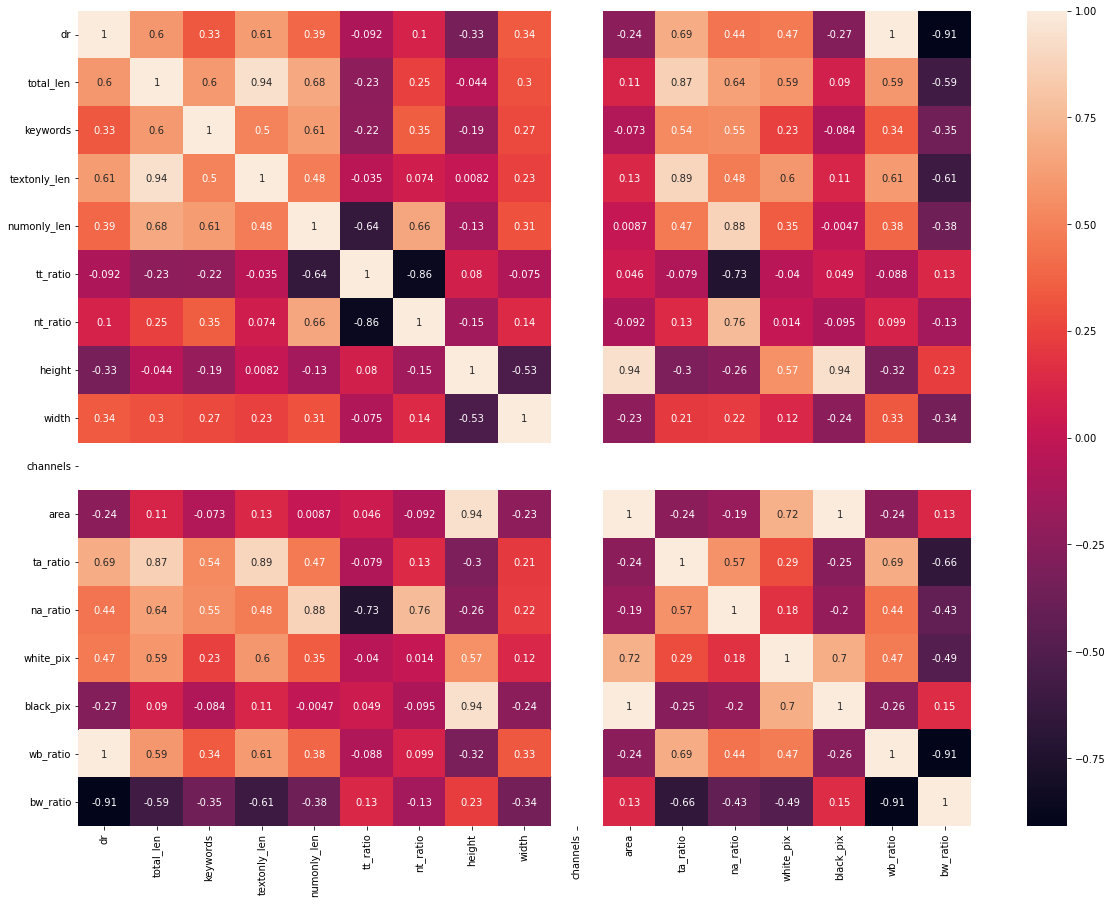

In [56]:
import seaborn as sns
correlation_mat = test.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [114]:
df_frame.actual[df_frame.actual =='CORRECT'] = 1
df_frame.actual[df_frame.actual =='WRONG'] = 0
df_frame.actual = df_frame.actual.astype('int')
dataset = df_frame.drop(['source','channels','white_pix','keywords'], axis = 1)
dataset.head()

<ipython-input-114-ef0feeb8276e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frame.actual[df_frame.actual =='CORRECT'] = 1
<ipython-input-114-ef0feeb8276e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frame.actual[df_frame.actual =='WRONG'] = 0


,actual,dr,total_len,textonly_len,numonly_len,tt_ratio,nt_ratio,height,width,area,ta_ratio,na_ratio,black_pix,wb_ratio,bw_ratio
0,1,8,61,36,9,0.918033,0.262295,1329,1654,2198166,2.547578,0.727880,2127142,0.033389,29.949623
1,1,10,48,19,16,0.729167,0.541667,679,1328,901712,3.881505,2.883404,863371,0.044408,22.518218
2,1,5,40,18,12,0.700000,0.425000,608,1565,951520,2.942660,1.786615,929509,0.023680,42.229294
3,1,14,134,88,14,0.947761,0.194030,754,1700,1281800,9.907942,2.028398,1207993,0.061099,16.366916
4,1,9,56,31,11,0.714286,0.321429,674,1654,1114796,3.588100,1.614645,1075222,0.036805,27.169910


In [115]:
labels[5]

'tt_ratio'

In [157]:
# on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
from sklearn.ensemble import ExtraTreesClassifier
labels = dataset.columns.drop(['actual'])
TOP_FEATURES = 14

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(dataset[labels], dataset['actual'])

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]
print(indices)
print('Top features:')
model_label=[]
for f in range(TOP_FEATURES):
    print('%d. feature %s (%f)' % (f + 1, labels[int(f)], importances[indices[f]]))
    model_label.append(labels[int(f)])
selected_x = model_label[:4]
selected_x

[ 3  4 10  6  5 11  8  1  9  7  0  2 12 13]
Top features:
1. feature dr (0.122701)
2. feature total_len (0.104652)
3. feature textonly_len (0.097275)
4. feature numonly_len (0.090284)
5. feature tt_ratio (0.086874)
6. feature nt_ratio (0.080190)
7. feature height (0.079178)
8. feature width (0.068143)
9. feature area (0.056513)
10. feature ta_ratio (0.052563)
11. feature na_ratio (0.042480)
12. feature black_pix (0.040569)
13. feature wb_ratio (0.039693)
14. feature bw_ratio (0.038886)


['dr', 'total_len', 'textonly_len', 'numonly_len']

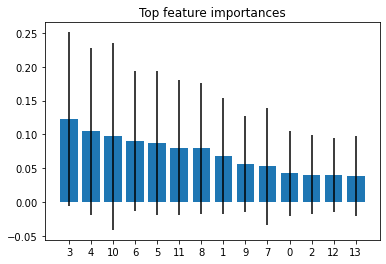

In [158]:
plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), indices)
plt.show()

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df_frame[selected_x] # Features
Y = df_frame.actual # Target variable

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[40,  2],
       [ 6,  1]])

Text(0.5, 257.44, 'Predicted label')

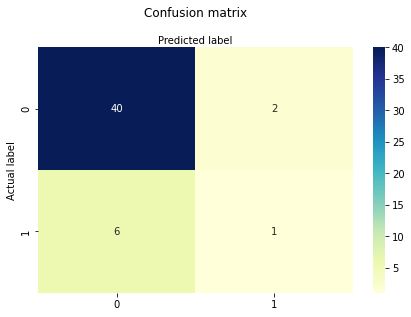

In [160]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [161]:
p=metrics.precision_score(y_test, y_pred)
r=metrics.recall_score(y_test, y_pred)
f1 = 2* ((p*r)/(p+r))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",p)
print("Recall:",r)
print("f1:",f1)

Accuracy: 0.8367346938775511
Precision: 0.3333333333333333
Recall: 0.14285714285714285
f1: 0.2
